# Lab Course: Distributed Data Analytics Exercise Sheet 1
<b>Submitted By: Mohit Bansal</b><br>
<b>Student ID: 279314</b><br>

## Exercise 0: Explain your system<br>

<b>System Specifications:</b><br>
MacBook Air (13-inch, 2017)<br>
Processor: 1.8 GHz Intel Core i5<br>
Memory: 8 GB 1600 MHz DDR3<br>
Graphics: Intel HD Graphics 6000 1536 MB<br>
Python Version: 3.6.3 64bit<br>

## Exercise 1: Basic Parallel Vector Operations with MPI (5Points) <br>

Suppose you are given a vector v ∈ RN . <br>
<ul>
<li>Initialize your vector v with random numbers (can be either integers or floating points) </li>
<li>You will experiment with three different sizes of vector, i.e. N = {$10^7$, $10^{12}$, $10^{15}$}. </li>
<li>You have to parallelize vector operations mentioned below using MPI API. </li>
<li>For each operation you will have to run experiment with varying number of workers, i.e. if your system has P workers than run experiments with workers = {1, 2, . . . P } for each size of vector given above. </li>
<li>You have to time your code for each operation and present it in a table. [Note: You have to define/explain your parallelization strategy i.e. how you assign task to each worker, how you divide your data etc.]. </li>
<li>You have to use MPI point-to-point communication i.e. Send and Recv.</li></ul>

### a) Add two vectors and store results in a third vector.

### Solution:

In order to solve this problem using ONLY point-to-point communication, we will break down the problem into the following steps:

1. Root node initializes 2 array lists of size N with random numbers

    $V_1$ = [$x_1$, $x_2$, $x_3$....$x_n$] <br>
    $V_2$ = [$y_1$, $y_2$, $y_3$....$y_n$] <br><br>
    
2. Root node divides the arrays sequentially into equal slices based on number of workers P 
    
    No. of slices (S) = Size of vector / No. of workers = $\frac{N}{P}$
    
    slice($W_i$) = [[$x_{S.i}$,$y_{S.i}$], [$x_{S.i + 1}$,$y_{S.i + 1}$]....[$x_{S.(i+1)-1}$,$y_{S.(i+1)-1}$]<br><br>
          
3. Root node sends each slice to respective worker<br><br>

4. Workers recieve the slice and add the respective pairs

   $z_i$ = $x_i$ + $y_i$ <br><br>
        
5. Workers send the intermediate sums back to root node <br><br>

6. Root node recieves data from workers and places in appropriate positions

**Note:** Based on testing, we should avoid sending and receiving from root node to itself as it is leading to deadlock.

|Test Case | # Processes | Avg. Computation time (Secs.) |
|----------|:-----------:|:-----------------------------:|
|$10^7$    |1	|1.410|
|$10^7$	   |4	|1.943|
|$10^7$	   |16	|1.820|
|$10^5$	   |1	|0.013|
|$10^5$    |4	|0.030|
|$10^5$    |16	|0.145|

This is counter-intuitive! The avg. computation time increases as we increase the no. of processors. The reason behind this is that since we are running our code on a single physical computer, the process are not "actually" running in parallel. Moreover, when multiple processes are being created, they are interleaved, thus each processes may take longer to finish.

Another reason behind this is that more processes require more resources. Creation, deletion of a process as well as resource allocation are intensive tasks and take up some CPU time as well.

Having said that, I believe that the results obtained in a truly distributed computing environment would have been quite the opposite.

Output with 4 processors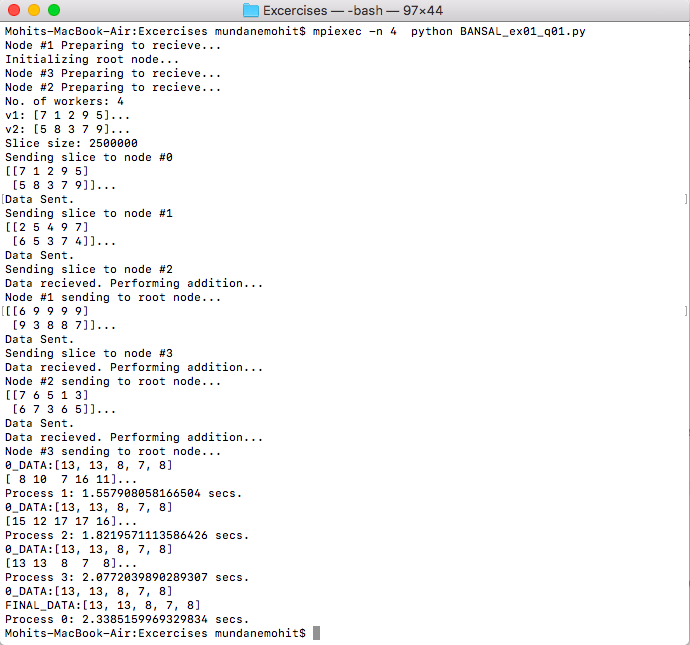

**Footnote:** Due to memory limitations, I was not able to initialize $10^{7}$+ sized arrays on my system. However, the logic works perfectly well for smaller vector sizes.


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 12 15:41:31 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import sys
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

wt = MPI.Wtime()

# Initializing vectors in root node 
if (rank == root):
    print("Initializing root node...")
    TC = [10**5, 10**7, 10**9]                    # Test Cases 
    size = comm.Get_size()                  # Get total number of running workers
    #N = input("Select Test Case: \n 1. 10^7 \n 2. 10^12 \n 3. 10^15 \n Selection: ")
    #N = int(N)
    N = 1                                  # SELECT TEST CASE HERE
    vec1 = np.random.randint(1,10, size = TC[N-1])
    vec2 = np.random.randint(1,10, size = TC[N-1])
    vec3 = []
    print('No. of workers: {}' .format(size))
    print('v1: {}...'.format(vec1[:5]))
    print('v2: {}...' .format(vec2[:5]))
    slice = int(Decimal(TC[N-1]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      # No. of elements each node will work on
    print('Slice size: {}'.format(slice))

    # Sending slices to workers
    # For root node, compute locally
    for i in range(0, size):
        print("Sending slice to node #{}" .format(i))
        if i == root:
           slice_pairs = np.array([vec1[0:slice],
                                   vec2[0:slice]])
        elif (i < size - 1):
            slice_pairs =  np.array([vec1[i*slice:(i+1)*slice],
                                     vec2[i*slice:(i+1)*slice]])
            comm.send(slice_pairs, dest = i)  # Send slices of vec1 & vec2 to each node
        # Send remaining data to last worker
        else:
            slice_pairs =  np.array([vec1[i*slice:],
                                     vec2[i*slice:]])
            comm.send(slice_pairs, dest = i)  # Send slices of vec1 & vec2 to each node
        print('{}...' .format(slice_pairs[:,:5]))
        print("Data Sent.")

else:
    # Each node recieves slices
    print("Node #{} Preparing to recieve..." .format(rank))
    data=comm.recv(source = root)
    # node adds up it's respective slices
    print('Data recieved. Performing addition...')
    temp_sum = data[0,:]+data[1,:]
    # And sends it back to root node
    print('Node #{} sending to root node...'.format(rank))
    comm.send(temp_sum, dest = root)
    #print('{}'.format(vec2))
    #vec3.insert(rank, temp_sum)
    print("{}...".format(temp_sum[:5]))

# Root node recieves the data and creates final array
if rank == root:
    for i in range(0, size):
        if i == root:
            vec3[0:0] = slice_pairs[0,:]+slice_pairs[1,:]
        else:
            DAT = comm.recv(source=MPI.ANY_SOURCE,status=status)
            sender=status.Get_source()
            vec3[sender*slice:sender*slice] = list(DAT)
        print('{}_DATA:{}'.format(rank, vec3[:5]))
    print('FINAL_DATA:{}'.format(vec3[:5]))

print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))
#MPI.Comm.Get_parent().Disconnect()

Initializing root node...
No. of workers: 1
v1: [6 1 7 8 9]...
v2: [5 8 1 9 4]...
Slice size: 100000
Sending slice to node #0
[[6 1 7 8 9]
 [5 8 1 9 4]]...
Data Sent.
0_DATA:[11, 9, 8, 17, 13]
FINAL_DATA:[11, 9, 8, 17, 13]
Process 0: 0.2784159183502197 secs.


## b) Find an average of numbers in a vector

### Solution:

Similar to the previous solution, 

1. Root node initializes an array lists of size N with random numbers

    $V_1$ = [$x_1$, $x_2$, $x_3$....$x_n$] <br><br>
    
2. Root node divides the arrays sequentially into equal slices based on number of workers P 
    
    No. of slices (S) = Size of vector / No. of workers = N/P
    
    slice($W_i$) = [[$x_{S.i}$], [$x_{S.i + 1}$]....[$x_{S.(i+1)-1}$]<br><br>
          
3. Root node sends each slice to respective worker<br><br>

4. Workers recieve the slice and average the values

   $\bar{z}_i$ = $\frac{\sum_{j=0}^{S-1} x_j}{S}$ <br><br>
        
5. Workers send the intermediate averages back to root node <br><br>
 
6. Root node adds up the intermediate averages from workers and divides by size of workers

   $\bar{x}$ = $\frac{\sum_{i=0}^{P-1} z_i}{N}$ 

|Test Case | # Processes | Avg. Computation time (Secs.) |
|----------|:-----------:|:-----------------------------:|
|$10^7$    |1	|0.161|
|$10^7$	   |4	|0.310|
|$10^7$	   |16	|0.400|
|$10^5$	   |1	|0.002|
|$10^5$    |4	|0.005|
|$10^5$    |16	|0.205|

**Explanation 1:** To speed up the processing, we are calculating an 'average of averages'. This results in a loss of precision. However, in case of extremely large datasets, this loss is negligible.

**Observation 1:** We also notice that the average of numbers in always ~50. This happened since we took the range as 1,100 and shows that the random numbers generated are always distributed normally.

**Alternative 1:** It is also possible to speed up the process even further. In this case, each node will send it's intermediate sum to the adjacent node instead of the master node. This process is repeated until we are left with only one node. This can be imagined as a reverse binary search tree.

Output with 4 processors:

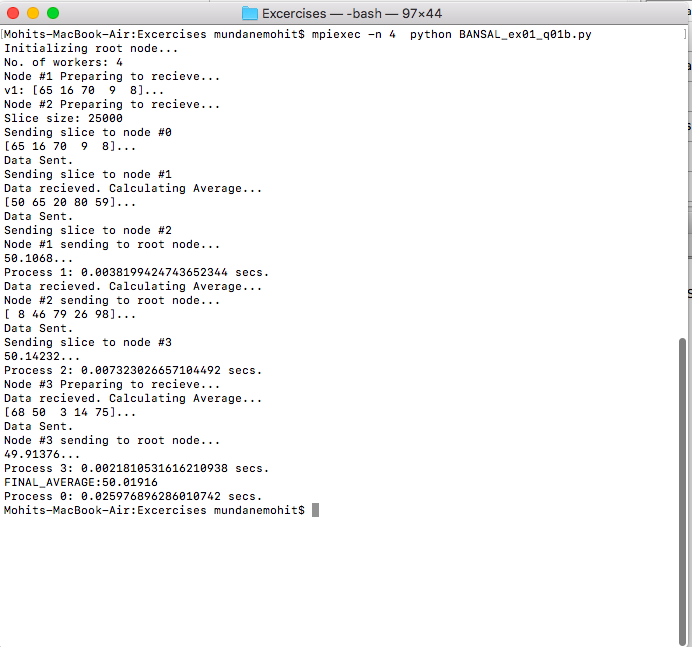


In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 15 15:42:32 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

wt = MPI.Wtime()

# Initializing vectors in root node 
# Sending slices to workers

if rank == root:
    print("Initializing root node...")
    TC = [10**5, 10**7, 10**9]              # Test Cases 
    size = comm.Get_size()                  # Get total number of running workers
    #N = input("Select Test Case: \n 1. 107 \n 2. 1012 \n 3. 1015 \n Selection: ")
    print('No. of workers: {}' .format(size))
    #N = int(N)
    N = 1                                   # SELECT TEST CASE HERE
    num_sum = 0
    vec1 = np.random.randint(1,100, size = TC[N-1])
   # vec3, data = [], []
    print('v1: {}...'.format(vec1[:5]))
    slice = int(Decimal(TC[N-1]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))     # No. of elements each node will work on
    print('Slice size: {}'.format(slice))
    for i in range(0, size):
        print("Sending slice to node #{}" .format(i))
        if i == root:
            slice_arr = vec1[0:slice]
        elif (i < size - 1):
            slice_arr =  vec1[i*slice:(i+1)*slice]
            comm.send(slice_arr, dest = i)  # Send slices of vec1 to each node
                # Send remaining data to last worker
        else:
            slice_arr =  vec1[i*slice:]
            comm.send(slice_arr, dest = i)  # Send slices of vec1 to each node
        print('{}...' .format(slice_arr[:5]))
        print("Data Sent.")

else:
    # Each node recieves slices
    print("Node #{} Preparing to recieve..." .format(rank))
    data=comm.recv(source = root)
    # node averages up it's respective slices
    print('Data recieved. Calculating Average...')
    temp_avg = np.sum(data)/len(data)
    # And sends it back to root node
    print('Node #{} sending to root node...'.format(rank))
    comm.send(temp_avg, dest = root)
    #print('{}'.format(vec2))
    #vec3.insert(rank, temp_sum)
    print("{}...".format(temp_avg))

if rank == root:
    for i in range(0, size):
        if i == root:
            num_sum =  np.sum(slice_arr)/len(slice_arr)
        else:
            DAT = comm.recv(source=MPI.ANY_SOURCE,status=status)   
            num_sum += DAT
    average = num_sum/size #len(vec1)
    print('FINAL_AVERAGE:{}'.format(average))
 #   print('ACTUAL_AVERAGE:{}' .format(np.average(vec1)))

print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))

#MPI.Comm.Get_parent().Disconnect()

Initializing root node...
No. of workers: 1
v1: [11  3 57 34 80]...
Slice size: 100000
Sending slice to node #0
[11  3 57 34 80]...
Data Sent.
FINAL_AVERAGE:49.88422
Process 0: 0.0487360954284668 secs.


## Exercise 2: Parallel Matrix Vector multiplication using MPI (7 Points)


In this exercise you have to work with a matrix A ∈ RN ×N and two vectors b ∈ RN , c ∈ RN
+ Initialize the matrix A and vector b with random numbers (can be either integers or floating points). 
+ The vector c will store result of A × b.
+ In case of matrix vector multiplication, you will experiment with three different sizes of matrices i.e. N = {$10^2$, $10^3$, $10^4$}. [note: your matrix will be N × N, which means in case 1 you will have matrix dimension 100x100]. 
+ You will have to run experiments with varying number of workers, i.e. if your system has P workers than run experiments with workers = {1, 2, . . . P } for each matrix size given above. 
+ You have to time your code and present it in a table.
+ Implement parallel matrix vector multiplication using MPI point-to-point communication i.e. Send and Recv. 
+ Explain your logic in the report i.e. how the matrix and vectors are divided (distributed) among workers, what is shared among them, how is the work distributed, what individual worker will do and what master worker will do.
+ Note: depending on your system RAM you might not be able to run experiment with matrix size n = $10^4$.




### Solution:

1. Root node initializes an array lists of size N and Matrix of size NxN with random numbers

    $MAT$ = <br>
    [$x_{1,1}$, $x_{1,2}$, ....$x_{1,n}$] <br>
    [$x_{2,1}$, $x_{2,2}$, ....$x_{2,n}$] <br>
    .<br>
    .<br>
    [$x_{n,1}$, $x_{n,2}$, ....$x_{n,n}$]
    
    $V$ = [$x_1$, $x_2$, $x_3$....$x_n$] <br><br>
    
2. Root node divides the matrix sequentially into equal slices based on number of workers P 
   
    No. of rows per slice (S) = Size of vector / No. of workers = N/P
    
    slice($M_i$) = 
    <br>
    [$x_{1,1}$, $x_{1,2}$, ....$x_{1,n}$] <br>
    [$x_{2,1}$, $x_{2,2}$, ....$x_{2,n}$] <br>
    .<br>
    .<br>
    [$x_{S.i,1}$, $x_{n,2}$, ....$x_{S.(i+1)-1,n}$] <br>br>
    
3. Root node attaches vector $V1$ on top of $MAT_s$ <br><br>

4. Root node sends each slice to respective worker<br><br>

5. Workers recieve the slice and perform multiplication

   $Result_i$ = $\sum_{j=0}^{N-1} {M_{0,j}}.{M_{i,j}}$ <br><br>
        
5. Workers send the intermediate sums back to root node <br><br>
 
6. Root node places the sums in appropriate positions

|Test Case | # Processes | Avg. Computation time (Secs.) |
|----------|:-----------:|:-----------------------------:|
|$10^3$    |1	|0.026|
|$10^3$	   |4	|0.050|
|$10^3$	   |16	|0.400|
|$10^2$	   |1	|0.002|
|$10^2$    |4	|0.050|
|$10^2$    |16	|0.070|


**Observation 1:** The processes which finish last generally have the longest running time due to interleaving. This is another issue which can be resolved with real distributed computing.

Output with 4 processors:

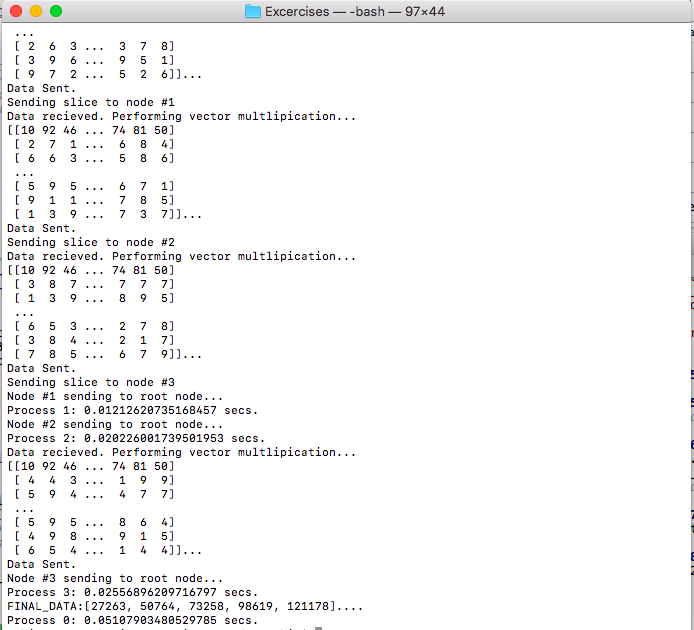

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 15 18:29:05 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

wt = MPI.Wtime()

# Initializing matrix & vectors in root node 
if rank == root:
    print("Initializing root node...")
    TC = [10**2, 10**3, 10**4]                    # Test Cases
    size = comm.Get_size()                  # Get total number of running workers
    #N = input("Select Test Case: \n 1. 107 \n 2. 1012 \n 3. 1015 \n Selection: ")
    #N = int(N)
    N = 1                                  # SELECT TEST CASE HERE
    matA = np.array([[np.random.randint(1,10) for i in range(TC[N-1])] for j in range(TC[N-1])])
    vecB = np.random.randint(1,100,size= TC[N-1])
    vecC = []
    print('No. of workers: {}' .format(size))
    print('Matrix A: \n{}...'.format(matA))
    print('Vector B: {}...' .format(vecB[:5]))
    slice = int(Decimal(TC[N-1]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      # No. of rows each node will work on
    print('Slice size: {}'.format(slice))

    # Sending slices to workers

    for i in range(0, size):
        print("Sending slice to node #{}" .format(i))
        if i == root:
            slice_pairs = np.vstack([vecB,matA[0:slice]])
        elif (i < size - 1):
            slice_pairs = np.vstack([vecB,matA[slice*i:slice*(i+1)]])
            comm.send(slice_pairs, dest = i)  # Send slices of vec1 & vec2 to each node
        # Send remaining data to last worker
        else:
            slice_pairs =  np.vstack([vecB, matA[i*slice:]])
            comm.send(slice_pairs, dest = i)  # Send slices of vec1 & vec2 to each node
        print('{}...' .format(slice_pairs))
        print("Data Sent.")

else:
    # Each node recieves slices
    print("Node #{} Preparing to recieve..." .format(rank))
    data=comm.recv(source = root)
    # node adds up it's respective slices
    print('Data recieved. Performing vector multlipication...')
    temp_sum=0
    temp_vec = []
    for i in range(1,len(data)):
        for j in range(len(data[0])):
            temp_sum += data[0][j]*data[i][j]
        temp_vec.append(temp_sum)
            
    # And sends it back to root node
    print('Node #{} sending to root node...'.format(rank))
    comm.send(temp_vec, dest = root)
    #print('{}'.format(vec2))
    #vec3.insert(rank, temp_sum)
    #print("{}...".format(temp_sum[:5]))

# Root node recieves the data and creates final array
if rank == root:
    for i in range(0, size):
      if i == root:
          temp_sum=0
          for i in range(1,len(slice_pairs)):
              for j in range(len(slice_pairs[0])):
                  temp_sum += slice_pairs[0][j]*slice_pairs[i][j]
              vecC.append(temp_sum)
      else:
          DAT = comm.recv(source=MPI.ANY_SOURCE,status=status)
          sender=status.Get_source()
          vecC[sender*slice:sender*slice] = list(DAT)
    print('FINAL_DATA:{}....'.format(vecC[:5]))

print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))
#MPI.Comm.Get_parent().Disconnect()

Initializing root node...
No. of workers: 1
Matrix A: 
[[5 3 3 ... 3 7 9]
 [8 9 1 ... 5 4 7]
 [6 5 7 ... 2 3 4]
 ...
 [1 5 3 ... 8 6 4]
 [4 2 5 ... 7 4 6]
 [6 5 5 ... 8 5 2]]...
Vector B: [83 84 17 58 48]...
Slice size: 100
Sending slice to node #0
[[83 84 17 ... 79 23 44]
 [ 5  3  3 ...  3  7  9]
 [ 8  9  1 ...  5  4  7]
 ...
 [ 1  5  3 ...  8  6  4]
 [ 4  2  5 ...  7  4  6]
 [ 6  5  5 ...  8  5  2]]...
Data Sent.
FINAL_DATA:[23555, 51128, 74591, 100982, 125707]....
Process 0: 0.029751062393188477 secs.



## Exercise 3: Parallel Matrix Operation using MPI (8 Points)

+ In this exercise you have to work with three matrices (A ∈ RN×N, B ∈ RN×N, C ∈ RN×N) i.e each matrix having size N ×N
+ Initialize your matrices A and B with random numbers (can be either integers or floating points). Matrix C will store result of A × B.
+ In case of matrix multiplication, you will experiment with three different sizes of matrices i.e. N = {$10^2$,  $10^3$, $10^4$}. 
+ [note: your matrix will be N × N, which means in case 1 you will have matrices with dimension 100x100]. 
+ You will have to run experiments with varying number of workers, i.e. if your system has P workers than run experiments with workers = {1, 2, . . . P } for each matrix size given above. 
+ You have to time your code and present it in a table.
+ Implement parallel matrix matrix multiplication using MPI collective communication. 
+ Explain your logic in the report i.e. how the matrices are divided (distributed) among workers, what is shared among them, how is the work distributed, what individual worker will do and what master worker will do. 
+ Perform experiments with varying matrix sizes and varying number of workers. You can look at the implementation provided in the lecture (slide 48) https://www.ismll.uni-hildesheim.de/lehre/bd-17s/ script/bd-01-parallel-computing.pdf
Note: depending on your system RAM you might not be able to run experiment with matrix size n = ${10^4}$

### Solution:

1. Root node initializes 2 Matrices of size NxN with random numbers

    $MAT1$ = <br>
    [$x_{1,1}$, $x_{1,2}$, ....$x_{1,n}$] <br>
    [$x_{2,1}$, $x_{2,2}$, ....$x_{2,n}$] <br>
    .<br>
    .<br>
    [$x_{n,1}$, $x_{n,2}$, ....$x_{n,n}$]
    
    $MAT2$ = <br>
    [$y_{1,1}$, $y_{1,2}$, ....$y_{1,n}$] <br>
    [$y_{2,1}$, $y_{2,2}$, ....$y_{2,n}$] <br>
    .<br>
    .<br>
    [$y_{n,1}$, $y_{n,2}$, ....$y_{n,n}$]
    
2. Root node divides the matrix A sequentially into equal slices based on number of workers P 
   
    No. of rows per slice (S) = Size of vector / No. of workers = N/P
    
    slice($M_i$) = 
    <br>
    [$x_{1,1}$, $x_{1,2}$, ....$x_{1,n}$] <br>
    [$x_{2,1}$, $x_{2,2}$, ....$x_{2,n}$] <br>
    .<br>
    .<br>
    [$x_{S.i,1}$, $x_{n,2}$, ....$x_{S.(i+1)-1,n}$] <br>br>
    
3. Root node **scatters** each slice of Matrix A to respective worker<br><br>

4. Matrix B is **broadcasted** to all nodes

5. Workers multiply the slice A and matrix B 
         
6. Root node **gathers** the data to create final NxN matrix

|Test Case | # Processes | Avg. Computation time (Secs.) |
|----------|:-----------:|:-----------------------------:|
|$10^3$    |1	|4.334|
|$10^3$	   |4	|6.500|
|$10^3$	   |16	|7.700|
|$10^2$	   |1	|0.038|
|$10^2$    |4	|0.060|
|$10^2$    |16	|0.150|


**Observation 1:** One of the major problems with scatter is that the no. of items to scatter should be equal to the number of processes. To overcome this issue, we wrap each slice into one block before scattering.

**Observation 2:** Our code is now much shorter and brief as compared to point-to-point communication. However, there is a tradeoff between lines of code and complicated data preparation steps.

**Observation 3:** The runtime increased by a factor of 100 by increasing dimension by a factor of 10. This is perfectly in sync since we are adding $10^2$ new dimensions.


Output with 4 processors:

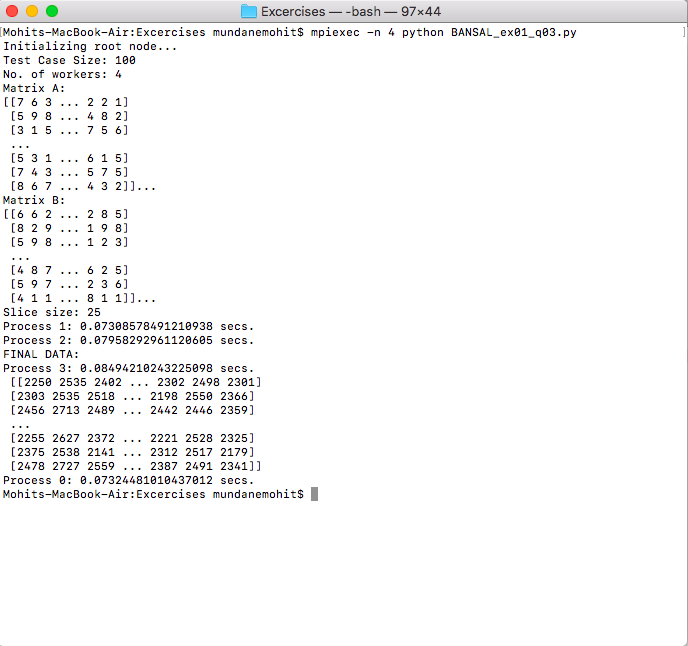

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Apr 15 18:29:05 2018

@author: mundanemohit
"""

from mpi4py import MPI                      # Load MPI Library
import numpy as np
from decimal import Decimal, ROUND_HALF_UP

comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # Current worker
status = MPI.Status()                       # Rank ID of sender
root = 0                                    # Setup root node

wt = MPI.Wtime()

# Initializing matrix & vectors in root node 
if rank == root:
    print("Initializing root node...")
    TC = [10**2, 10**3, 10**4]                    # Test Cases
    size = comm.Get_size()                  # Get total number of running workers
    #N = input("Select Test Case: \n 1. 107 \n 2. 1012 \n 3. 1015 \n Selection: ")
    #N = int(N)
    N = 1                                 # SELECT TEST CASE HERE
    matA = np.array([[np.random.randint(1,10) for i in range(TC[N-1])] for j in range(TC[N-1])])
    matB = np.array([[np.random.randint(1,10) for i in range(TC[N-1])] for j in range(TC[N-1])])
    matC = []
    print('Test Case Size: {}' .format(TC[N-1]))
    print('No. of workers: {}' .format(size))
    print('Matrix A: \n{}...'.format(matA))
    print('Matrix B: \n{}...' .format(matB))
    slice = int(Decimal(TC[N-1]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      # No. of rows each node will work on
    print('Slice size: {}'.format(slice))

    sliceA = []
    for i in range(0,size):
        if i < size - 1:
            sliceA.append([matA[slice*i:slice*(i+1)]])
        else:
            sliceA.append([matA[slice*i:]])
else:
    sliceA = None
    matB = None

#Broadcasting B
matB = comm.bcast(matB, root = root)

# Sending slices to workers   
sliceA = comm.scatter(sliceA, root = root)

# Multiplying slice to matrix
sliceAB = np.matmul(np.squeeze(sliceA), matB)

# Gathering slices
matAB = np.squeeze(comm.gather(sliceAB))

if rank == root:
    matAB = np.concatenate(matAB)
    matAB = np.reshape(matAB, (TC[N-1],TC[N-1]))
    print('FINAL DATA:\n', matAB)
print('Process {}: {} secs.' .format(rank, MPI.Wtime() - wt))


Initializing root node...
Test Case Size: 100
No. of workers: 1
Matrix A: 
[[1 4 8 ... 8 6 2]
 [4 6 6 ... 1 8 2]
 [7 3 1 ... 1 2 7]
 ...
 [7 3 4 ... 1 9 8]
 [9 4 8 ... 2 4 4]
 [7 6 8 ... 3 4 4]]...
Matrix B: 
[[2 3 1 ... 9 6 6]
 [8 7 4 ... 6 3 5]
 [3 6 2 ... 4 7 4]
 ...
 [2 7 2 ... 2 7 8]
 [9 3 8 ... 4 5 3]
 [6 9 6 ... 4 5 1]]...
Slice size: 100
FINAL DATA:
 [[2333 2744 2263 ... 2513 2464 2297]
 [2529 2775 2391 ... 2728 2480 2544]
 [2628 2804 2543 ... 2755 2733 2608]
 ...
 [2218 2733 2311 ... 2588 2548 2374]
 [2172 2719 2371 ... 2610 2443 2372]
 [2559 3110 2547 ... 2905 2846 2619]]
Process 0: 0.05808901786804199 secs.


1. Palach, Jan. Parallel Programming with Python. Packt Publishing Ltd, 2014.
2. To time your program you have to use MPI.Wtime(): http://nullege.com/codes/search/mpi4py.
MPI.Wtime
3. MPI4PY tutorial 1(Python): http://mpi4py.scipy.org/docs/usrman/tutorial.html
4. MPI4PY tutorial 2(Python): https://portal.tacc.utexas.edu/c/document_library/get_file? uuid=be16db01-57d9-4422-b5d5-17625445f351&groupId=13601
5. MPI tutorial (C/C++): https://computing.llnl.gov/tutorials/mpi/
6. Matrix Operation: http://stattrek.com/matrix-algebra/matrix-multiplication.aspx